In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [ ]:
!pip install colabgymrender==1.0.2
!pip install gym pyvirtualdisplay > /dev/null 2>&1
# !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt update && apt install xvfb

  Created wheel for colabgymrender: filename=colabgymrender-1.0.2-py3-none-any.whl size=2444 sha256=01842568d121899594cb809a772332e439209acfdbc3014df9d4dbcfd1ae69a6
  Stored in directory: /root/.cache/pip/wheels/1f/56/73/3697080da5fc7b120516aef37d1d1eb2380515ba9e272b8ccd
Successfully built colabgymrender
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:9 https://developer.downlo

In [ ]:
from colabgymrender.recorder import Recorder

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)974848/45929032 bytes (2.1%)2736128/45929032 bytes (6.0%)4251648/45929032 bytes (9.3%)5595136/45929032 bytes (12.2%)7684096/45929032 bytes (16.7%)9535488/45929032 bytes (20.8%)11542528/45929032 bytes (25.1%)12951552/45929032 bytes (28.2%)14860288/45929032 bytes (32.4%)16875520/45929032 bytes (36.7%)18997248/45929032 bytes (41.4%)21356544/45929032 bytes (46.5%)23093248/45

In [ ]:
env = gym.make('MountainCar-v0')
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0

while not done:
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    state = next_state

print(total_reward)
env.play()


-200.0


100%|█████████▉| 201/202 [00:00<00:00, 293.44it/s]


In [ ]:
total_reward

-200.0

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, env):
        super(NeuralNetwork, self).__init__()
    
        self.network = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 64),
            nn.ReLU(),
            # nn.Tanh(),
            nn.Linear(64, env.action_space.n)
        )
    
    def forward(self, state):
        return self.network(state)
    
    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self(state.unsqueeze(0)) # pytorch requires inputs in terms of batch
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()

In [ ]:
def fill_memory(env):
    memory = deque(maxlen=memory_size)
    state = env.reset()
    for _ in range(min_replay_size):
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        state = next_state
        if done:
            env.reset()
    
    return memory

In [ ]:
def dqn_training(env, max_num_steps, max_epsilon, min_epsilon, num_epsilon_decay_intervals, gamma, lr):
    q_net = NeuralNetwork(env)
    target_net = NeuralNetwork(env)
    target_net.load_state_dict(q_net.state_dict())
    optimizer = torch.optim.Adam(q_net.parameters(), lr=lr)

    memory = fill_memory(env)
    reward_buffer = deque(maxlen=100) # Rewards of the previous 100 episodes

    reward_per_episode = 0.0
    state = env.reset()
    all_rewards = []
    for step in range(max_num_steps):
        epsilon = np.interp(step, [0, num_epsilon_decay_intervals], [max_epsilon, min_epsilon])

        random_number = np.random.uniform(0,1)
        if random_number <= epsilon:
            action = env.action_space.sample()
        else:
            action = q_net.choose_action(state)
        
        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        reward_per_episode += reward

        state = next_state

        if done:
            state = env.reset()
            reward_buffer.append(reward_per_episode)
            all_rewards.append((step, reward_per_episode))
            reward_per_episode = 0.0

        
        # Take a batch of experiences from the memory
        experiences = random.sample(memory, batch_size)
        states = [ex[0] for ex in experiences]
        actions = [ex[1] for ex in experiences]
        rewards = [ex[2] for ex in experiences]
        dones = [ex[3] for ex in experiences]
        next_states = [ex[4] for ex in experiences]

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(-1)
        next_states = torch.tensor(next_states, dtype=torch.float32)

        # Compute targets using the formulation sample = r + gamma * max q(s',a')
        target_q_values = target_net(next_states)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
        targets = rewards + gamma * (1-dones) * max_target_q_values

        # Compute loss
        q_values = q_net(states)

        action_q_values = torch.gather(input=q_values, dim=1, index=actions)
        loss = torch.nn.functional.mse_loss(action_q_values, targets)

        # gradient descent for q-network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update target network
        if (step+1) % target_update_frequency == 0:
            target_net.load_state_dict(q_net.state_dict())

        # print training results
        if (step+1) % 1000 == 0:
            average_reward = np.mean(reward_buffer)
            print(f'Episode: {len(all_rewards)} Step: {step+1} Average reward: {average_reward}')

    return all_rewards, q_net

In [ ]:
""" This is baseline """

# Hyperparameters
max_epsilon = 1.0
min_epsilon = 0.01
max_num_steps = 50000
epsilon_decay_intervals = 10000
gamma = 0.99 # discount
alpha = 5e-4 # learning rate

memory_size = 50000
min_replay_size = 1000
batch_size = 32

target_update_frequency = 1000 # target network update frequency

In [ ]:
# Hyperparameters
max_epsilon = 1.0
min_epsilon = 0.01
max_num_steps = 100000
epsilon_decay_intervals = 10000
gamma = 0.99 # discount
alpha = 1e-3 # learning rate

memory_size = 100000
min_replay_size = 1000
batch_size = 128

target_update_frequency = 1000 # target network update frequency

In [ ]:
all_rewards, q_net = dqn_training(env, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, lr=alpha)

Episode: 5 Step: 1000 Average reward: -200.0
Episode: 10 Step: 2000 Average reward: -200.0
Episode: 15 Step: 3000 Average reward: -200.0
Episode: 20 Step: 4000 Average reward: -200.0
Episode: 25 Step: 5000 Average reward: -200.0
Episode: 30 Step: 6000 Average reward: -200.0
Episode: 35 Step: 7000 Average reward: -200.0
Episode: 40 Step: 8000 Average reward: -200.0
Episode: 45 Step: 9000 Average reward: -200.0
Episode: 50 Step: 10000 Average reward: -200.0
Episode: 55 Step: 11000 Average reward: -200.0
Episode: 60 Step: 12000 Average reward: -199.75
Episode: 65 Step: 13000 Average reward: -199.76923076923077
Episode: 70 Step: 14000 Average reward: -199.78571428571428
Episode: 75 Step: 15000 Average reward: -199.8
Episode: 80 Step: 16000 Average reward: -199.8125
Episode: 85 Step: 17000 Average reward: -199.25882352941176
Episode: 90 Step: 18000 Average reward: -199.25555555555556
Episode: 95 Step: 19000 Average reward: -198.65263157894736
Episode: 100 Step: 20000 Average reward: -198.27

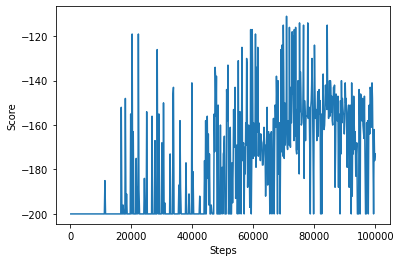

In [ ]:
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])

In [ ]:
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
q_net.eval()

with torch.no_grad():
    while not done:
        #action = env.action_space.sample()
        action = q_net.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

-170.0


 99%|█████████▉| 171/172 [00:00<00:00, 288.45it/s]
